# Projection on vertical modes

This notebook contains instruction for computing mean strat and corresponding vertical modes, and then project fields onto this basis. It is written to deal with cos/sin harmonics fields but the method is general.

N.B.: in this case, linear EOS with Tcoef=1, hence $\rho=T$

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as gop
from crocosi.vmodes import get_vmodes

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(dashboard_address=':8788')
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42235 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


# Read netcdf file

In [3]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp6_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='file_',
           grid_params=gparams, verbose=True)

### fixing a few stuff. WARNING quick & dirty
# time is nan
#r['his'].coords['mytime'] = xr.DataArray(np.arange(r['his']["time"].size), dims=["time"])

#r['his']

Analysing directory /home/datawork-lops-osi/aponte/bturb_itide/jet/jet_cfg1_wp6_4km_nodecay_2000a2300j/
Found 3 segments
Found 12 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his']
Grid size: (L ,M, N) = (258, 722, 50)


# Compute mean stratification

**ssh temporal mean**

<xarray.DataArray 'ssh_a' (y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(722, 258), dtype=float32, chunksize=(722, 258), chunktype=numpy.ndarray>
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_w      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f_rho    (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    f_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805


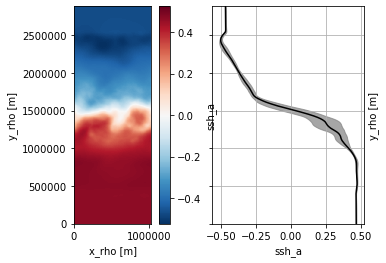

In [4]:
# eventually should also average along x
ssh_mean_t = r['his'].ssh_a.mean(dim='time').persist()
print(ssh_mean_t)

fig, axs = plt.subplots(1, 2, sharey=True)
ssh_mean_tx = ssh_mean_t.mean(dim="x_rho")
ssh_std = ssh_mean_t.std(dim="x_rho")
ssh_mean_t.plot(ax=axs[0])
ssh_mean_t.mean(dim="x_rho").plot(ax=axs[1], y="y_rho", color="k")
axs[1].fill_betweenx(r.ds['his'].y_rho, 
                     ssh_mean_tx-ssh_std, 
                     ssh_mean_tx+ssh_std, 
                     color="grey", alpha=.7)

axs[1].grid(True)
axs[1].yaxis.set_label_position("right")
axs[0].set_aspect('equal')

**Compute z mean from ssh mean**

<xarray.DataArray 'z_rho' (s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<add, shape=(50, 722, 258), dtype=float64, chunksize=(50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_w      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f_rho    (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    f_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.0

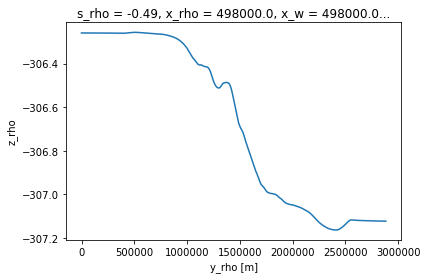

In [5]:
zr_mean = r.get_z(zeta=ssh_mean_t, #h = r['grid'].h.mean('x_rho'),
                vtransform='old').persist()
zw_mean = r.get_z(zeta=ssh_mean_t,
                vgrid='w',
                vtransform='old').persist()
#zmean.isel(x_rho=125).plot(x='y_rho', y='s_rho')
print(zr_mean)
zr_mean.isel(x_rho=125).sel(s_rho=-.5, method='nearest').plot(x='y_rho')

**Interpolate vertically stratification T(x,y,z,t)  on zmean -> T(x,y,$\bar{z}$,t)**

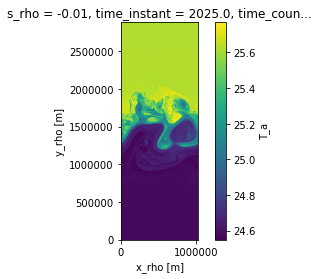

In [6]:
p = r['his'].T_a.isel(time=0, s_rho=-1).plot()
p.axes.set_aspect('equal')

### compute/lazy-load z and T
zr = r.get_z(zeta=r['his'].ssh_a, vtransform='old')
T = r['his'].T_a.chunk({'s_rho':None})

<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258, time: 12)>
dask.array<interp2z, shape=(50, 722, 258, 12), dtype=float64, chunksize=(50, 722, 258, 1), chunktype=numpy.ndarray>
Coordinates:
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_w           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_w           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f_rho         (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    f_w           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f 

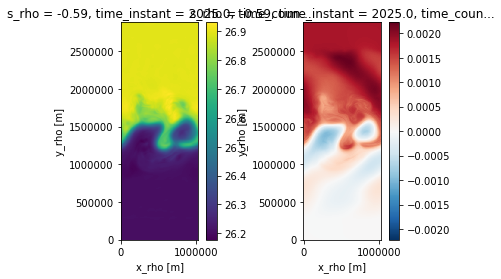

In [7]:
### interpolate T on mean z-grid
Ti = xr.apply_ufunc(gop.interp2z, zr_mean, zr, T, 2, 2,
                    dask='parallelized', 
                    output_dtypes=[np.float64])
Ti = Ti.assign_coords(z_rho=zr_mean)
print(Ti)

ax = plt.subplot(1,2,1)
Ti.isel(time=0, s_rho=20).plot(ax=ax, title='Ti')
ax.set_aspect('equal')
#
ax = plt.subplot(1,2,2)
(T-Ti).isel(time=0, s_rho=20).plot(ax=ax, title='T-Ti')
ax.set_aspect('equal')

**Temporal mean of stratification T(x,y,$\bar{z}$,t) -> T(x,y,$\bar{z}$)**

<xarray.DataArray (s_rho: 50, y_rho: 722, x_rho: 258)>
dask.array<mean_agg-aggregate, shape=(50, 722, 258), dtype=float64, chunksize=(50, 722, 258), chunktype=numpy.ndarray>
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_w      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f_rho    (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    f_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 258), meta=np.ndarray>

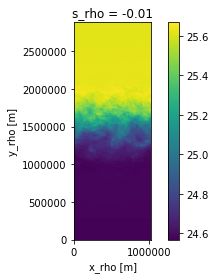

In [8]:
T_mean = Ti.mean(dim='time')
p = T_mean.isel(s_rho=-1).plot()
p.axes.set_aspect('equal')
T_mean

**Compute N2 profile from stratification on mean z  T(x,y,$\bar{z}$) -> N2(x,y,$\bar{z}$)**

<xarray.DataArray (s_w: 51, y_rho: 722, x_rho: 258)>
dask.array<where, shape=(51, 722, 258), dtype=float64, chunksize=(49, 722, 258), chunktype=numpy.ndarray>
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
Dimensions without coordinates: s_w

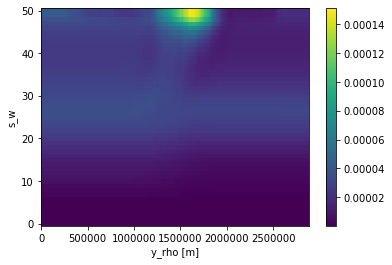

In [9]:
N2 = r.get_N2(T_mean, zr_mean).persist()
p = N2.mean(dim="x_rho").plot()
N2

In [10]:
N2.mean(dim="x_rho").values

array([[1.16782848e-07, 1.16781789e-07, 1.16781453e-07, ...,
        1.03684061e-07, 1.03685339e-07, 1.03670472e-07],
       [1.16782848e-07, 1.16781789e-07, 1.16781453e-07, ...,
        1.03684061e-07, 1.03685339e-07, 1.03670472e-07],
       [1.51954041e-07, 1.51948346e-07, 1.51947566e-07, ...,
        1.17776159e-07, 1.17777978e-07, 1.17772413e-07],
       ...,
       [3.67725488e-05, 3.67738827e-05, 3.67734687e-05, ...,
        1.78624444e-05, 1.78619947e-05, 1.78663195e-05],
       [4.22514386e-05, 4.22641115e-05, 4.22634647e-05, ...,
        1.93826748e-05, 1.93826438e-05, 1.93936934e-05],
       [4.22514386e-05, 4.22641115e-05, 4.22634647e-05, ...,
        1.93826748e-05, 1.93826438e-05, 1.93936934e-05]])

**Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)**

Use compute_vmodes function and wrapper for using with dask/xarray


CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 62.3 ms
CPU times: user 252 ms, sys: 40 ms, total: 292 ms
Wall time: 5.69 s


<xarray.Dataset>
Dimensions:  (mode: 11, s_rho: 50, s_w: 51, x_rho: 1, y_rho: 722)
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0
    y_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_w      (x_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v      (x_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    f_rho    (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
    f_w      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    z_rho    (s_rho, y_rho, x_rho) float64 dask.array<chunksize=(50, 722, 1), meta=np.ndarray>
    z_w      (s_w, y_rho, x_rho) float64 dask.array<chunksize=(51, 722, 1), meta=np.ndarray>
    N2       (s_w, y_rho, x_rho) float64 dask.array<chunksize=(1, 722, 1), meta=np.ndarray>
    norm     (y_rho, x_rho) float64 dask.array<chunksize=(722, 1), meta=np.ndarray>
Dimensions without coordinates: s_w
Data variables:
    c        (mode, y_rho, x_rho) float64 dask.array<chunksize=(11, 722, 1), meta=np.ndarray>
    phi      (mode, s_rho, y_rho, x_rho) float64 dask.array<chunksize=(11, 50, 722, 1), meta=np.ndarray>
    dphidz   (mode, s_w, y_rho, x_rho) float64 dask.array<chunksize=(11, 51, 722, 1), meta=np.ndarray>

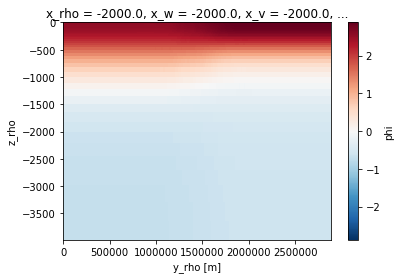

In [15]:
# compute mode on a y slice: that works fine
%time vmodes = get_vmodes(zr_mean.isel(x_rho=[0]), zw_mean.isel(x_rho=[0]), N2.isel(x_rho=[0]))
%time vmodes.phi.sel(mode=1).plot(x="y_rho", y="z_rho")
vmodes

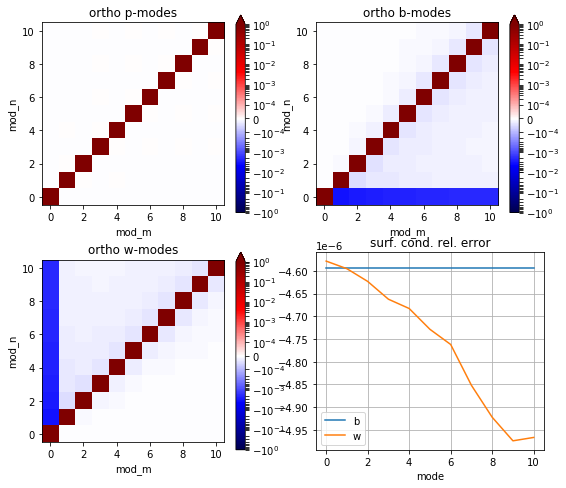

In [13]:
### check orthogonality and free surf condition -- buoy modes
# the small error in w is probably due to mismatch at the surf of integrated phi
fig, axs = plt.subplots(2, 2, figsize=(9,8))
axs = axs.ravel()

h_mean = r["grid"].h.mean()

grid = r['xgrid']
sds = ds.isel(x_rho=0, y_rho=0).persist()
modn = sds.phi.rename({'mode':'mod_n'})
modm = sds.phi.rename({'mode':'mod_m'})
orthomat = (grid.diff(sds.z_w, "s")*modn*modm).sum("s_rho")/h_mean
orthomat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[0])
axs[0].set_title('ortho p-modes')

grav = 9.81
# buoyancy modes, = d phi / dz
mobn = sds.dphidz.rename({'mode':'mod_n'})
mobm = sds.dphidz.rename({'mode':'mod_m'})
orthobat = (mobn*mobm/N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mobn.isel(s_w=-1)*mobm.isel(s_w=-1)/N2.isel(y_rho=0,x_rho=0,s_w=-1)**2 
            #+ modn.isel(s_rho=-1)*modm.isel(s_rho=-1)/grav
orthobat *= sds.c.rename({'mode':'mod_n'})**2/h_mean
orthobat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[1])
axs[1].set_title('ortho b-modes')

# w modes, = int(phi)
mown = grid.cumsum(grid.diff(sds.z_w, "s")*sds.phi, "s", to="outer", boundary="fill")
mown = mown.assign_coords(z_w=sds.z_w).rename({"mode":"mod_n"})
mowm = mown.rename({"mod_n":"mod_m"})
orthowat = (mown*mowm*N2.isel(y_rho=0,x_rho=0)).integrate(dim="z_w") \
            + grav* mown.isel(s_w=-1)*mowm.isel(s_w=-1)
orthowat /= sds.c.rename({'mode':'mod_n'})**2*h_mean
orthowat.plot.imshow(norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1,vmax=1), cmap="seismic", ax=axs[2])
axs[2].set_title('ortho w-modes')

# check free surface condition : w(0) = c²/g p(0)
ax = axs[3]
relerb = 1 + N2.isel(x_rho=0,y_rho=0,s_w=-1)*sds.phi.isel(s_rho=-1)/grav/sds.dphidz.isel(s_w=-1)
relerb.plot(ax=ax, label="b")
relerw = 1 - sds.phi.isel(s_rho=-1)*sds.c**2/grav/mown.isel(s_w=-1).rename({'mod_n':'mode'})
relerw.plot(ax=ax, label='w')
ax.set_title('surf. cond. rel. error')
ax.grid(True)
ax.ticklabel_format(style='sci',scilimits=(-2,3))
ax.legend()

for ax in axs[:3]:
    ax.set_aspect('equal')
    
fig.subplots_adjust(wspace=.2)

# Projection of a variable on vertical modes

**Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)**

this is still ongoing work

In [14]:
# define get_p (not sure this is correct)
# it would be nice to be able to interpolate from w-grid to r-grid (e.g. get rid of broadcasting)
# I think p is wrong for now

def get_p_zmoy(ds, zr, zw, rho, zrho=None):
    _g = 9.81
    grid = ds.attrs['xgrid']
    if zrho is not None:
        rho = xr.apply_ufunc(interp2z, zr, zrho, rho, False, \
                    dask='parallelized', output_dtypes=[np.float64])
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    pres = pres - pres.isel(s_w=-1) # how to get cumsum going the other way ?
    return grid.interp(pres, "s")

def get_p(r, ds, rho, zeta, z=None):
    """ this is the baroclinic pressure, without rho0*zeta and int(rho0) """
    # this is a bit wrong, because variable boundary for integration of rho makes pressure nonlinear
    
    _g = 9.81
    zw = get_z(r, zeta, h=ds.h, vgrid='w', hgrid='r')
    grid = ds.attrs['xgrid']
    pres =  grid.cumsum(grid.diff(zw, "s")*rho*_g, "s", to="outer", boundary="fill") 
    if z is None:
        return grid.interp(pres, "s")
    else:
        return xr.apply_ufunc(interp2z, z, zw.chunk({'s_w':-1}), pres.chunk({'s_w':-1}), False, \
                    input_core_dims=[['s_rho'],['s_w'],['s_w'],[]], output_core_dims=[['s_rho']], \
                    dask='parallelized', output_dtypes=[np.float64])


In [15]:
# project p, u and v
### not using interpolated field because can't extrapolate, hence nan                                        

ds = r['his']
grid = ds.attrs['xgrid']
dz = grid.diff(zf, "s")
hwean = np.abs(zwean.isel(s_w=-1)-zwean.isel(s_w=0))

### first pressure
#pp = get_p(r, ds, ds.T_t_cos, ds.ssh_t_cos)
pp = get_p_zmoy(ds, zmean, zwean, ds.T_t_cos, z)
pn = (dz*pp*phin).sum("s_rho")/hwean

### then x-velocity
ur = grid.interp(ds.u_t_cos, "xi").rename({'y_u':'y_rho'}) # question: does grid.interp know how to broadcast?
#ur = xr.apply_ufunc(interp2z, zmean, z, ur, True, 
#                    dask='parallelized', output_dtypes=[np.float64])
un = (dz*ur*phin).sum("s_rho")/hwean

### then y-velocity
vv = r['his'].v_t_cos
vr = grid.interp(vv, "eta").rename({'x_v':'x_rho'})
vn = (dz*vr*phin).sum("s_rho")/hwean


NameError: name 'zf' is not defined

In [17]:
ds.T_t_cos.isel(time=0,x_rho=jj).plot()

NameError: name 'jj' is not defined

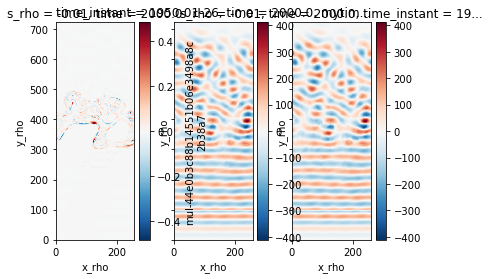

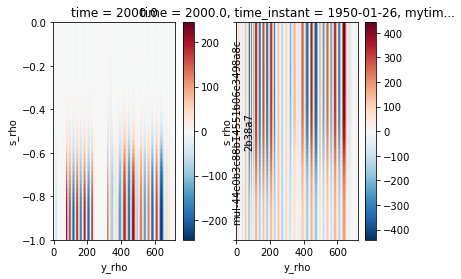

In [72]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

psurf = pp.isel(s_rho=-1).isel(time=0)
etap = (ds.ssh_t_cos*(r.params['rho0']+T.isel(s_rho=-1))*9.81).isel(time=0)

psurf.plot(ax=axs[0])
etap.plot(ax=axs[1])
(psurf+etap).plot(ax=axs[2])

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
psec = pp.isel(x_rho=jj).isel(time=0)
ptot = psec + etap.isel(x_rho=jj)
psec.plot(ax=axs[0])
pbcl.plot(ax=axs[1])

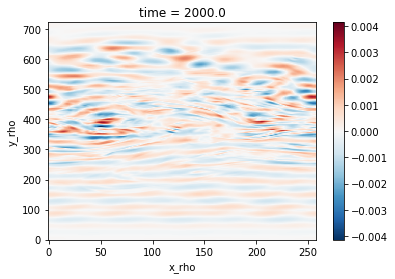

In [127]:
un.isel(time=0,modes=0).plot(x="x_rho")

In [17]:
### u2rho returns " KeyError: 'X' "
uu = r['his'].u_t_cos.isel(x_u=[jj,jj+1]).mean("x_u")

ui = xr.apply_ufunc(interp2z, zmean, z, uu, False, 
                    dask='parallelized', output_dtypes=[np.float64])

### I need to switch dim from "s_w" to "s_rho" for dz
### same for u, v -> need u2rho, v2rho and have xarray understand y_u = y_rho
un = (zwean.diff('s_w')*ui*phin).sum("s_rho")

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.3 ms
